In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, hstack
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from xgboost import plot_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
data = pd.read_table("/content/drive/MyDrive/ML_Project/mbti_1.csv",delimiter=',',header=None).iloc[1:, :]

In [ ]:
data.shape

(8675, 2)

# **Data Exploration**

In [ ]:
Personalities = np.unique(np.array(data.iloc[:,0]))
print(*Personalities)
print("Number of personalities: ", len(Personalities))

ENFJ ENFP ENTJ ENTP ESFJ ESFP ESTJ ESTP INFJ INFP INTJ INTP ISFJ ISFP ISTJ ISTP
Number of personalities:  16


In [ ]:
Posts_per_personality = (data.groupby([0]).count()*50)
print("Number of posts per personality:")
Posts_per_personality

Number of posts per personality:


,1
0,
ENFJ,9500
ENFP,33750
ENTJ,11550
ENTP,34250
ESFJ,2100
ESFP,2400
ESTJ,1950
ESTP,4450
INFJ,73500


Text(0.5, 1.0, 'Total posts for each personality type')

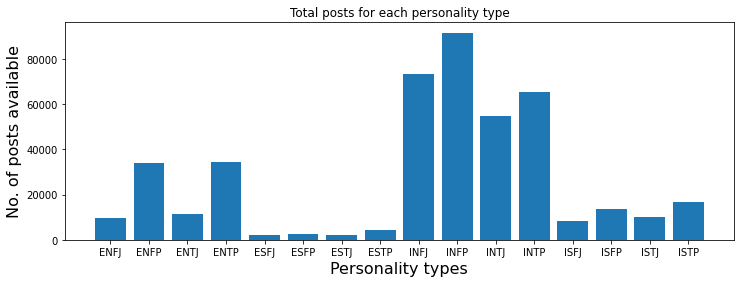

In [ ]:
ax = plt.figure(figsize = (12,4))
rects1 = plt.bar(np.array(Posts_per_personality.index), height = Posts_per_personality[1])
plt.xlabel('Personality types', size = 16)
plt.ylabel('No. of posts available', size = 16)
plt.title('Total posts for each personality type')
# plt.savefig('type_vs_posts.png')

In [ ]:
def get_types(row):
    t=row[0]

    I = 0; N = 0
    T = 0; J = 0
    
    if (t[0] == 'I'):
      I = 1
    elif (t[0] == 'E'):
      I = 0
    else:
      print('Wrong Personality')
      return
        
    if (t[1] == 'N'):
      N = 1
    elif (t[1] == 'S'):
      N = 0
    else:
      print('Wrong Personality') 
      return
        
    if (t[2] == 'T'):
      T = 1
    elif (t[2] == 'F'):
      T = 0
    else:
      print('Wrong Personality') 
      return
        
    if (t[3] == 'J'):
      J = 1
    elif (t[3] == 'P'):
      J = 0
    else:
      print('Wrong Personality') 
      return 

    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

mapped_data = data.copy()
mapped_data = mapped_data.join(mapped_data.apply (lambda row: get_types (row),axis=1))
mapped_data.head(5)

,0,1,IE,NS,TF,JP
1,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
2,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
3,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
4,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
5,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [ ]:
print("Samples per personality category:-")
print ("Introversion (I) /  Extroversion (E):\t", mapped_data['IE'].value_counts()[0], " / ", mapped_data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", mapped_data['NS'].value_counts()[0], " / ", mapped_data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", mapped_data['TF'].value_counts()[0], " / ", mapped_data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", mapped_data['JP'].value_counts()[0], " / ", mapped_data['JP'].value_counts()[1])

Samples per personality category:-
Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


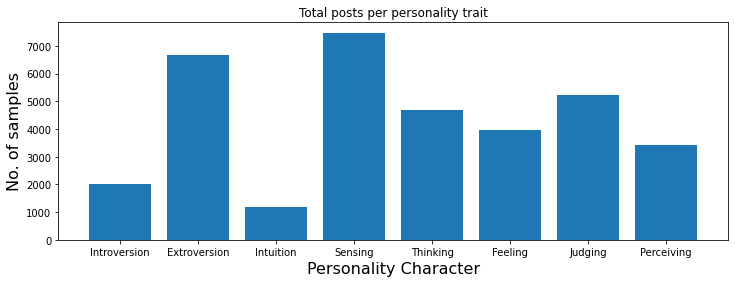

In [ ]:
num_I = mapped_data['IE'].value_counts()[0]
num_E = mapped_data['IE'].value_counts()[1]
num_N = mapped_data['NS'].value_counts()[0]
num_S = mapped_data['NS'].value_counts()[1]
num_T = mapped_data['TF'].value_counts()[0]
num_F = mapped_data['TF'].value_counts()[1]
num_J = mapped_data['JP'].value_counts()[0]
num_P = mapped_data['JP'].value_counts()[1]
ax = plt.figure(figsize = (12,4))
rects1 = plt.bar(["Introversion", "Extroversion", "Intuition", "Sensing", "Thinking", "Feeling", "Judging", "Perceiving"], [num_I, num_E, num_N, num_S, num_T, num_F, num_J, num_P])
plt.xlabel('Personality Character', size = 16)
plt.ylabel('No. of samples', size = 16)
plt.title('Total posts per personality trait')
plt.savefig('each_trait_vs_posts.png')

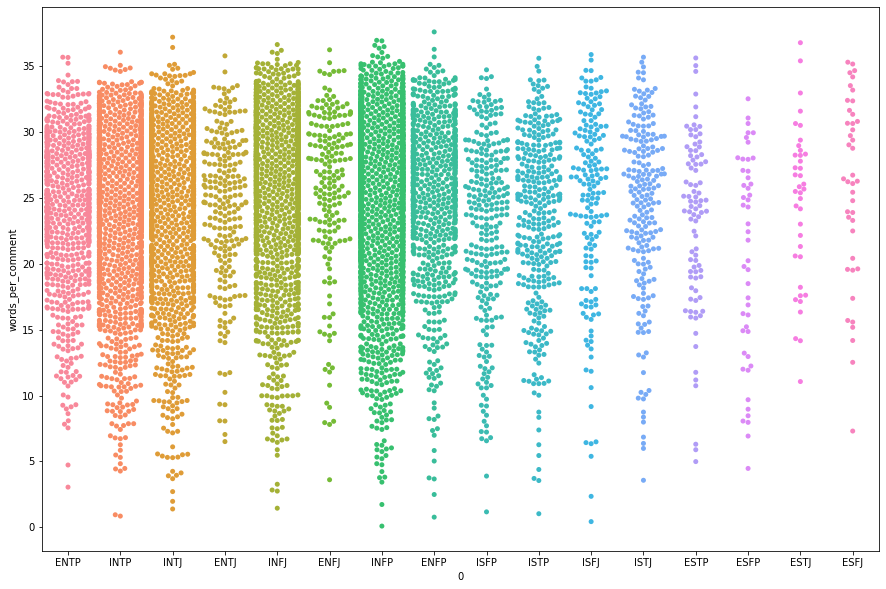

In [ ]:
df = data.iloc[1:,:].copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    row = row.split("|||")
    for i in row:
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df[1].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df[1].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns_plot = sns.swarmplot(0, "words_per_comment", data=df)
# sns_plot.savefig("swarmplot.png")

<Figure size 720x720 with 0 Axes>

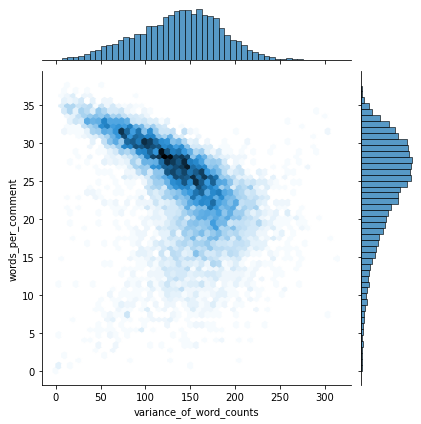

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot("variance_of_word_counts", "words_per_comment", data=df, kind="hex")

In [ ]:
#Finding the most common words in all posts.
words = list(df[1].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(20)

[('I', 387949),
 ('to', 290158),
 ('the', 270680),
 ('a', 230903),
 ('and', 219487),
 ('of', 177838),
 ('is', 128801),
 ('you', 128746),
 ('that', 127215),
 ('in', 117248),
 ('my', 104556),
 ('it', 93099),
 ('for', 83048),
 ('have', 79784),
 ('with', 77127),
 ('but', 74729),
 ('be', 69312),
 ('are', 65032),
 ('like', 61387),
 ('not', 59492)]

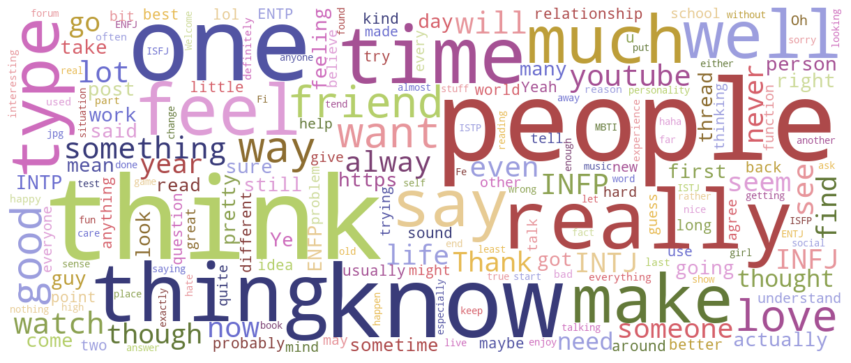

In [ ]:
#Plotting the most common words with WordCloud.
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(15,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

# **Pre-Processing**

In [ ]:
def preprocess_text(df_old, remove_special=True):
    df = df_old.copy()

    # Remove links 
    df[1] = df[1].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df[1] = df[1].apply(lambda x: re.sub(r'\.', '', x + " "))
    df[1] = df[1].apply(lambda x: re.sub(r'\?', '', x + " "))
    df[1] = df[1].apply(lambda x: re.sub(r'!', '', x + " "))
    
    #Strip Punctation
    df[1] = df[1].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df[1] = df[1].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df[1] = df[1].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert1to lowercase
    df[1] = df[1].apply(lambda x: x.lower())


    #Remove MBTI codes
    for i in ['isfj','isfp', 'infj', 'infp', 'intj', 'intp', 'estp', 'estj', 'esfp', 'esfj', 'enfp', 'enfj', 'entp', 'entj']:
      df[1] = df[1].apply(lambda x: re.sub(i, '', x))

    #Remove multiple letter repeating words
    df[1] = df[1].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very long words
    df[1] = df[1].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
    
    rows = df.shape[0]
    for i in range(rows):
      sentence = df.iloc[i,1]
      # Tokenize: Split the sentence into words
      word_list = nltk.word_tokenize(sentence)

      # Lemmatize list of words and join
      # ps = PorterStemmer()
      # lemmatized_output = ' '.join([ps.stem(w) for w in word_list])
      
      lemmatizer = WordNetLemmatizer()
      lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

      df.iloc[i,1] = lemmatized_output

    return df

# Preprocessing of entered Text
new_df = preprocess_text(data)

In [ ]:
rows=data.shape[0]
for i in range(rows):
  sent = data.iloc[i,1]
  print(sent)
  break

'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|

In [ ]:
new_df.head()

,0,1
1,INFJ,and moment sportscenter not top ten play prank...
2,ENTP,im finding the lack of me in these post very a...
3,INTP,good one of course to which i say i know thats...
4,INTJ,dear i enjoyed our conversation the other day ...
5,ENTJ,youre fired thats another silly misconception ...


# **Direction 1** - *16 Class Classification*

**Making Targets**

In [ ]:
# Converting MBTI personality (or target or Y feature) into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df[0])
target_16C = new_df['type of encoding']

**Feature Extraction - 1 (Count Vectorizer)**

In [ ]:
vect_count = CountVectorizer(stop_words='english') 
data_count =  vect_count.fit_transform(new_df[1])

**Feature Extraction - 2 (Tfidf Vectorizer)**

In [ ]:
vect_tfidf = TfidfVectorizer()
data_tfidf = vect_tfidf.fit_transform(new_df[1])

**Raw Data -> (Train_Validation)/Test Split (80-20%)**

In [ ]:
validation_size = 0.2
X_train_test_CoVe_16C, X_validation_CoVe_16C, y_train_test_CoVe_16C, y_validation_test_CoVe_16C = train_test_split(data_count, target_16C, test_size=validation_size, stratify=target_16C)
print(X_train_test_CoVe_16C.shape, X_validation_CoVe_16C.shape)

X_train_test_tfidf_16C, X_validation_tfidf_16C, y_train_test_tfidf_16C, y_validation_test_tfidf_16C = train_test_split(data_tfidf, target_16C, test_size=validation_size, stratify=target_16C)
print(X_train_test_tfidf_16C.shape, X_validation_tfidf_16C.shape)

(6940, 91333) (1735, 91333)
(6940, 91591) (1735, 91591)


**Train -> Train-Validation Split (85-15%)**

In [ ]:
test_size = 0.15
X_train_CoVe_16C, X_test_CoVe_16C, y_train_CoVe_16C, y_test_CoVe_16C = train_test_split(X_train_test_CoVe_16C, y_train_test_CoVe_16C, test_size=test_size, stratify=y_train_test_CoVe_16C)
print(X_train_CoVe_16C.shape, X_test_CoVe_16C.shape)

X_train_tfidf_16C, X_test_tfidf_16C, y_train_tfidf_16C, y_test_tfidf_16C = train_test_split(X_train_test_tfidf_16C, y_train_test_tfidf_16C, test_size=test_size, stratify=y_train_test_tfidf_16C)
print(X_train_tfidf_16C.shape, X_test_tfidf_16C.shape)

(5899, 91333) (1041, 91333)
(5899, 91591) (1041, 91591)


Applying Models

In [ ]:
def evaluate(testlabel, y_pred):
	print(classification_report(testlabel,y_pred))
	print()
	from sklearn.metrics import confusion_matrix

	cm1 = confusion_matrix(testlabel,y_pred)
	total1=sum(sum(cm1))
	accuracy1=(cm1[0,0]+cm1[1,1])/total1

	sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
	print('Sensitivity : ', sensitivity1 )
	print()

	specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
	print('Specificity : ', specificity1)
	print()

	from sklearn.metrics import cohen_kappa_score
	print("Cohen Kappa Score: ", cohen_kappa_score(testlabel, y_pred))
	
	print()
	from sklearn.metrics import matthews_corrcoef
	print("MCC Score: ", matthews_corrcoef(testlabel, y_pred))
	
	# print()
	# from sklearn.metrics import roc_auc_score
	# print("AUC ROC Score: ",roc_auc_score(testlabel, y_pred))
	# print()

In [ ]:
accuracies_count = {}
accuracies_tfidf = {}

# Count Vectorizer

        #Random Forest
random_forest_CoVe = RandomForestClassifier()
random_forest_CoVe.fit(X_train_CoVe_16C, y_train_CoVe_16C)

        # Making predictions for test data
Y_pred_CoVe = random_forest_CoVe.predict(X_test_CoVe_16C)
predictions_CoVe = [round(value) for value in Y_pred_CoVe]

        # Evaluating Predictions
accuracy_CoVe = accuracy_score(y_test_CoVe_16C, predictions_CoVe)
accuracies_count['Random Forest'] = accuracy_CoVe* 100.0 
print("Stats with Count Vectorizer's feature vectors")
print("Accuracy: " + str(accuracy_CoVe * 100.0) + "%")
evaluate(y_test_CoVe_16C, predictions_CoVe)

print()
# tfidf

        #Random Forest
random_forest_tfidf = RandomForestClassifier()
random_forest_tfidf.fit(X_train_tfidf_16C, y_train_tfidf_16C)

        # Making predictions for test data
Y_pred_tfidf = random_forest_tfidf.predict(X_test_tfidf_16C)
predictions_tfidf = [round(value) for value in Y_pred_tfidf]

        # Evaluating Predictions
accuracy_tfidf = accuracy_score(y_test_tfidf_16C, predictions_tfidf)
accuracies_tfidf['Random Forest'] = accuracy_tfidf* 100.0 
print("Stats with tf-idf's feature vectors")
print("Accuracy: " + str(accuracy_tfidf * 100.0) + "%")
evaluate(y_test_tfidf_16C, predictions_tfidf)


Stats with Count Vectorizer's feature vectors
Accuracy: 38.13640730067243%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.47      0.11      0.18        81
           2       0.00      0.00      0.00        28
           3       0.50      0.06      0.11        82
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        11
           8       0.42      0.50      0.46       176
           9       0.32      0.86      0.47       220
          10       0.52      0.26      0.35       131
          11       0.47      0.46      0.46       156
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00        32
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        40

    a

# **Direction 2**- *Taking 4 binary categories seperately (Making an ensemble of models)*

**Making Targets**

In [ ]:
def get_types(row):
    t=row[0]

    I = 0; N = 0
    T = 0; J = 0
    
    if (t[0] == 'I'):
      I = 1
    elif (t[0] == 'E'):
      I = 0
    else:
      print('Wrong Personality')
      return
        
    if (t[1] == 'N'):
      N = 1
    elif (t[1] == 'S'):
      N = 0
    else:
      print('Wrong Personality') 
      return
        
    if (t[2] == 'T'):
      T = 1
    elif (t[2] == 'F'):
      T = 0
    else:
      print('Wrong Personality') 
      return
        
    if (t[3] == 'J'):
      J = 1
    elif (t[3] == 'P'):
      J = 0
    else:
      print('Wrong Personality') 
      return 

    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

mapped_data = new_df.copy()
mapped_data = mapped_data.join(mapped_data.apply (lambda row: get_types (row),axis=1))
mapped_data.head(5)

,0,1,IE,NS,TF,JP
1,INFJ,and moment sportscenter not top ten play prank...,1,1,0,1
2,ENTP,im finding the lack of me in these post very a...,0,1,1,0
3,INTP,good one of course to which i say i know thats...,1,1,1,0
4,INTJ,dear i enjoyed our conversation the other day ...,1,1,1,1
5,ENTJ,youre fired thats another silly misconception ...,0,1,1,1


**Removing immbalance from ensemble analysis**

In [ ]:
def remove_imbalance(data, column):
  values = data[column].value_counts()
  # print(values)
  num_values = min(values[0],values[1])
  # print(num_values)
  data = shuffle(data)
  new_data = shuffle(pd.concat([data.loc[data[column] == 1].iloc[:num_values, :], data.loc[data[column] == 0].iloc[:num_values, :]]))
  return new_data

mapped_data_IE = remove_imbalance(mapped_data, "IE")
mapped_data_NS = remove_imbalance(mapped_data, "NS")
mapped_data_TF = remove_imbalance(mapped_data, "TF")
mapped_data_JP = remove_imbalance(mapped_data, "JP")
print(mapped_data_IE['IE'].value_counts())
print(mapped_data_NS['NS'].value_counts())
print(mapped_data_TF['TF'].value_counts())
print(mapped_data_JP['JP'].value_counts())

1    1999
0    1999
Name: IE, dtype: int64
1    1197
0    1197
Name: NS, dtype: int64
1    3981
0    3981
Name: TF, dtype: int64
1    3434
0    3434
Name: JP, dtype: int64


**Extracting Targets**

In [ ]:
target_mapped_df_IE = mapped_data_IE[["IE", "NS", "TF", "JP"]]
target_mapped_df_NS = mapped_data_NS[["IE", "NS", "TF", "JP"]]
target_mapped_df_TF = mapped_data_TF[["IE", "NS", "TF", "JP"]]
target_mapped_df_JP = mapped_data_JP[["IE", "NS", "TF", "JP"]]

# Feature Extraction

**Feature Extraction - 1 (Count Vectorizer)**

In [ ]:
vect_count_IE = CountVectorizer(stop_words='english') 
data_count_IE =  vect_count_IE.fit_transform(mapped_data_IE[1])

vect_count_NS = CountVectorizer(stop_words='english') 
data_count_NS =  vect_count_NS.fit_transform(mapped_data_NS[1])

vect_count_TF = CountVectorizer(stop_words='english') 
data_count_TF =  vect_count_TF.fit_transform(mapped_data_TF[1])

vect_count_JP = CountVectorizer(stop_words='english') 
data_count_JP =  vect_count_JP.fit_transform(mapped_data_JP[1])

**Feature Extraction - 2 (Tf-idf Vectorizer)**

In [ ]:
# vect_tfidf = TfidfVectorizer()
# data_tfidf = vect_tfidf.fit_transform(new_df[1])

vect_tfidf_IE = TfidfVectorizer()
data_tfidf_IE =  vect_tfidf_IE.fit_transform(mapped_data_IE[1])

vect_tfidf_NS = TfidfVectorizer()
data_tfidf_NS =  vect_tfidf_NS.fit_transform(mapped_data_NS[1])

vect_tfidf_TF = TfidfVectorizer()
data_tfidf_TF =  vect_tfidf_TF.fit_transform(mapped_data_TF[1])

vect_tfidf_JP = TfidfVectorizer()
data_tfidf_JP =  vect_tfidf_JP.fit_transform(mapped_data_JP[1])

# Train-Test Split

**Raw Data -> (Train_Test)/Validation Split (80-20%)** #CountVectotrizer

In [ ]:
validation_size = 0.2
print("IE")
X_train_test_CoVe_IE, X_validation_CoVe_IE, y_train_test_CoVe_IE, y_validation_test_CoVe_IE = train_test_split(data_count_IE, target_mapped_df_IE, test_size=validation_size, stratify=target_mapped_df_IE)
print(X_train_test_CoVe_IE.shape, X_validation_CoVe_IE.shape)

print("NS")
X_train_test_CoVe_NS, X_validation_CoVe_NS, y_train_test_CoVe_NS, y_validation_test_CoVe_NS = train_test_split(data_count_NS, target_mapped_df_NS, test_size=validation_size, stratify=target_mapped_df_NS)
print(X_train_test_CoVe_NS.shape, X_validation_CoVe_NS.shape)

print("TF")
X_train_test_CoVe_TF, X_validation_CoVe_TF, y_train_test_CoVe_TF, y_validation_test_CoVe_TF = train_test_split(data_count_TF, target_mapped_df_TF, test_size=validation_size, stratify=target_mapped_df_TF)
print(X_train_test_CoVe_TF.shape, X_validation_CoVe_TF.shape)

print("JP")
X_train_test_CoVe_JP, X_validation_CoVe_JP, y_train_test_CoVe_JP, y_validation_test_CoVe_JP = train_test_split(data_count_JP, target_mapped_df_JP, test_size=validation_size, stratify=target_mapped_df_JP)
print(X_train_test_CoVe_JP.shape, X_validation_CoVe_JP.shape)

IE
(3198, 62915) (800, 62915)
NS
(1915, 47476) (479, 47476)
TF
(6369, 97046) (1593, 97046)
JP
(5494, 88726) (1374, 88726)


**Train -> Train-Test Split (90-10%)** # CountVectorizer

In [ ]:
test_size = 0.1
X_train_CoVe_IE, X_test_CoVe_IE, y_train_CoVe_IE, y_test_CoVe_IE = train_test_split(X_train_test_CoVe_IE, y_train_test_CoVe_IE, test_size=test_size, stratify=y_train_test_CoVe_IE)
print(X_train_CoVe_IE.shape, X_test_CoVe_IE.shape)

X_train_CoVe_NS, X_test_CoVe_NS, y_train_CoVe_NS, y_test_CoVe_NS = train_test_split(X_train_test_CoVe_NS, y_train_test_CoVe_NS, test_size=test_size, stratify=y_train_test_CoVe_NS)
print(X_train_CoVe_NS.shape, X_test_CoVe_NS.shape)

X_train_CoVe_TF, X_test_CoVe_TF, y_train_CoVe_TF, y_test_CoVe_TF = train_test_split(X_train_test_CoVe_TF, y_train_test_CoVe_TF, test_size=test_size, stratify=y_train_test_CoVe_TF)
print(X_train_CoVe_TF.shape, X_test_CoVe_TF.shape)

X_train_CoVe_JP, X_test_CoVe_JP, y_train_CoVe_JP, y_test_CoVe_JP = train_test_split(X_train_test_CoVe_JP, y_train_test_CoVe_JP, test_size=test_size, stratify=y_train_test_CoVe_JP)
print(X_train_CoVe_JP.shape, X_test_CoVe_JP.shape)

(2878, 62915) (320, 62915)
(1723, 47476) (192, 47476)
(5732, 97046) (637, 97046)
(4944, 88726) (550, 88726)


**Raw Data -> (Train_Test)/Validation Split (80-20%)** #tf-idf

In [ ]:
validation_size = 0.2
print("IE")
X_train_test_tfidf_IE, X_validation_tfidf_IE, y_train_test_tfidf_IE, y_validation_test_tfidf_IE = train_test_split(data_tfidf_IE, target_mapped_df_IE, test_size=validation_size, stratify=target_mapped_df_IE)
print(X_train_test_tfidf_IE.shape, X_validation_tfidf_IE.shape)

print("NS")
X_train_test_tfidf_NS, X_validation_tfidf_NS, y_train_test_tfidf_NS, y_validation_test_tfidf_NS = train_test_split(data_tfidf_NS, target_mapped_df_NS, test_size=validation_size, stratify=target_mapped_df_NS)
print(X_train_test_tfidf_NS.shape, X_validation_tfidf_NS.shape)

print("TF")
X_train_test_tfidf_TF, X_validation_tfidf_TF, y_train_test_tfidf_TF, y_validation_test_tfidf_TF = train_test_split(data_tfidf_TF, target_mapped_df_TF, test_size=validation_size, stratify=target_mapped_df_TF)
print(X_train_test_tfidf_TF.shape, X_validation_tfidf_TF.shape)

print("JP")
X_train_test_tfidf_JP, X_validation_tfidf_JP, y_train_test_tfidf_JP, y_validation_test_tfidf_JP = train_test_split(data_tfidf_JP, target_mapped_df_JP, test_size=validation_size, stratify=target_mapped_df_JP)
print(X_train_test_tfidf_JP.shape, X_validation_tfidf_JP.shape)

IE
(3198, 63218) (800, 63218)
NS
(1915, 47779) (479, 47779)
TF
(6369, 97353) (1593, 97353)
JP
(5494, 89032) (1374, 89032)


**Train -> Train-Test Split (90-10%)** # tf-idf

In [ ]:
test_size = 0.1
X_train_tfidf_IE, X_test_tfidf_IE, y_train_tfidf_IE, y_test_tfidf_IE = train_test_split(X_train_test_tfidf_IE, y_train_test_tfidf_IE, test_size=test_size, stratify=y_train_test_tfidf_IE)
print(X_train_tfidf_IE.shape, X_test_tfidf_IE.shape)

X_train_tfidf_NS, X_test_tfidf_NS, y_train_tfidf_NS, y_test_tfidf_NS = train_test_split(X_train_test_tfidf_NS, y_train_test_tfidf_NS, test_size=test_size, stratify=y_train_test_tfidf_NS)
print(X_train_tfidf_NS.shape, X_test_tfidf_NS.shape)

X_train_tfidf_TF, X_test_tfidf_TF, y_train_tfidf_TF, y_test_tfidf_TF = train_test_split(X_train_test_tfidf_TF, y_train_test_tfidf_TF, test_size=test_size, stratify=y_train_test_tfidf_TF)
print(X_train_tfidf_TF.shape, X_test_tfidf_TF.shape)

X_train_tfidf_JP, X_test_tfidf_JP, y_train_tfidf_JP, y_test_tfidf_JP = train_test_split(X_train_test_tfidf_JP, y_train_test_tfidf_JP, test_size=test_size, stratify=y_train_test_tfidf_JP)
print(X_train_tfidf_JP.shape, X_test_tfidf_JP.shape)

(2878, 63218) (320, 63218)
(1723, 47779) (192, 47779)
(5732, 97353) (637, 97353)
(4944, 89032) (550, 89032)


In [ ]:
train_test_dataset_mapping = {
    "IE": [X_train_CoVe_IE, X_test_CoVe_IE, y_train_CoVe_IE, y_test_CoVe_IE ],
    "NS": [X_train_CoVe_NS, X_test_CoVe_NS, y_train_CoVe_NS, y_test_CoVe_NS],
    "TF": [X_train_CoVe_TF, X_test_CoVe_TF, y_train_CoVe_TF, y_test_CoVe_TF],
    "JP": [X_train_CoVe_JP, X_test_CoVe_JP, y_train_CoVe_JP, y_test_CoVe_JP ]
}
categories = ["IE", "NS", "TF", "JP"]


train_test_dataset_mapping = {
    "IE": [X_train_CoVe_IE, X_test_CoVe_IE, y_train_CoVe_IE, y_test_CoVe_IE ],
    "NS": [X_train_CoVe_NS, X_test_CoVe_NS, y_train_CoVe_NS, y_test_CoVe_NS],
    "TF": [X_train_CoVe_TF, X_test_CoVe_TF, y_train_CoVe_TF, y_test_CoVe_TF],
    "JP": [X_train_CoVe_JP, X_test_CoVe_JP, y_train_CoVe_JP, y_test_CoVe_JP ]
}
categories = ["IE", "NS", "TF", "JP"]


# Evaluation Function

In [ ]:
def evaluate_D2(testlabel, y_pred):
  print(classification_report(testlabel,y_pred))
  print()

  cm1 = confusion_matrix(testlabel,y_pred)
  total1=sum(sum(cm1))
  accuracy1=(cm1[0,0]+cm1[1,1])/total1

  sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
  print('Sensitivity : ', sensitivity1 )
  print()

  specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
  print('Specificity : ', specificity1)
  print()

  
  ckappa = cohen_kappa_score(testlabel, y_pred)
  print("Cohen Kappa Score: ", ckappa)
  
  print()
  
  mcc = matthews_corrcoef(testlabel, y_pred)
  print("MCC Score: ", mcc)
  
  print()
  
  roc_auc = roc_auc_score(testlabel, y_pred)
  print("AUC ROC Score: ",roc_auc)
  print()

  avg_precision = average_precision_score(testlabel, y_pred)

  avg_recall_score = recall_score(testlabel, y_pred)

  avg_f1_score = f1_score(testlabel, y_pred)
  # Accuracy, Sensitivity, Specificity, Cohen Kappa, MCC, Precision, Recall, F1, Auc_Roc
  return [accuracy1, sensitivity1, specificity1, ckappa, mcc, avg_precision, avg_recall_score, avg_f1_score, roc_auc]

# Applying Models (Count Vectorizer)

*Random Forest*

In [ ]:

# rf_accuracy = {}
# for cat in categories:
#   #Random Forest
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   random_forest = RandomForestClassifier()
#   random_forest.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = random_forest.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   rf_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))


IE Mean Accuracy:  0.6244131455399061
NS Mean Accuracy:  0.6449086161879896
TF Mean Accuracy:  0.7229199372056515
JP Mean Accuracy:  0.6056466302367942


*XGBoost Classifier*

In [ ]:
# # XGBoost Classifier
# xgb_accuracy = {}
# for cat in categories:
#   #Random Forest
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   xgb = XGBClassifier()
#   xgb.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = xgb.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   xgb_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

IE Mean Accuracy:  0.6369327073552425
NS Mean Accuracy:  0.6788511749347258
TF Mean Accuracy:  0.717425431711146
JP Mean Accuracy:  0.6083788706739527


*Logistic Regression*

In [ ]:
# # Logistic Regression Classifier
# lr_accuracy = {}
# for cat in categories:
#   # Logistic Regression
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   lr = LogisticRegression()
#   lr.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = lr.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   lr_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

IE Mean Accuracy:  0.6494522691705791
NS Mean Accuracy:  0.6736292428198434
TF Mean Accuracy:  0.7409733124018838
JP Mean Accuracy:  0.6293260473588342


*SVM Classifier*

In [ ]:
# # SVM Classifier
# svm_accuracy = {}
# for cat in categories:
#   # SVM
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   svc_cls = SVC(C= 1, gamma='scale', kernel='rbf')
#   svc_cls.fit(X_train, y_train_temp)
  

#   # make predictions for test data
#   Y_pred = svc_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   svm_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()
#   break


# from sklearn.model_selection import cross_val_score
# clf = SVC()
# scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
# print("IE Mean Accuracy: ", max(scores))

# clf = SVC()
# scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
# print("NS Mean Accuracy: ", max(scores))

# clf = SVC()
# scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
# print("TF Mean Accuracy: ", max(scores))

# clf = SVC()
# scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
# print("JP Mean Accuracy: ", max(scores))


print("Before Hyperparameter Tuning.....\n")
clf = SVC(C=10)
clf.fit(X_train_CoVe_IE, y_train_CoVe_IE['IE'])
predictions = clf.predict(X_test_CoVe_IE)
evaluate_D2(y_test_CoVe_IE['IE'], predictions)
print()
print()


Before Hyperparameter Tuning.....

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       160
           1       0.70      0.57      0.63       160

    accuracy                           0.66       320
   macro avg       0.67      0.66      0.66       320
weighted avg       0.67      0.66      0.66       320


Sensitivity :  0.75

Specificity :  0.575

Cohen Kappa Score:  0.32499999999999996

MCC Score:  0.33009386547736663

AUC ROC Score:  0.6625





In [ ]:
import pickle
  
saved_model = pickle.dumps(clf)
  
# knn_from_pickle = pickle.loads(saved_model)
  
# test_predictions = knn_from_pickle.predict(X_validation_CoVe_IE)
# evaluate_D2(y_validation_test_CoVe_IE['IE'],test_predictions)

*MLP Classifier*

In [ ]:
# # MLP Classifier
# mlp_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   mlp_cls = MLPClassifier()
#   mlp_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = mlp_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   mlp_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

IE Mean Accuracy:  0.6181533646322379
NS Mean Accuracy:  0.7049608355091384


*Extra Trees Classifier*

In [ ]:
# # Extra Trees Classifier
# etree_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   etree_cls = ExtraTreesClassifier()
#   etree_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = etree_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   etree_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

*Decision Tree Classifier*

In [ ]:
# # Decision Tree Classifier
# dt_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   dt_cls = DecisionTreeClassifier()
#   dt_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = dt_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   dt_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

*KNeighbors Classifier*

In [ ]:
# # KNeighbors Classifier
# kn_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   kn_cls = KNeighborsClassifier()
#   kn_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = kn_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   kn_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()



from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_IE, y_train_test_CoVe_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_NS, y_train_test_CoVe_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_TF, y_train_test_CoVe_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_CoVe_JP, y_train_test_CoVe_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

# Applying Models (tf-idf)

Random Forest

In [ ]:

# rf_accuracy = {}
# for cat in categories:
#   #Random Forest
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   random_forest = RandomForestClassifier()
#   random_forest.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = random_forest.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   rf_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))


IE Mean Accuracy:  0.5978090766823161
NS Mean Accuracy:  0.6527415143603134
TF Mean Accuracy:  0.6970172684458399
JP Mean Accuracy:  0.592896174863388


XGBoost Classifier

In [ ]:
# # XGBoost Classifier
# xgb_accuracy = {}
# for cat in categories:
#   #Random Forest
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   xgb = XGBClassifier()
#   xgb.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = xgb.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   xgb_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = XGBClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

IE Mean Accuracy:  0.6291079812206573
NS Mean Accuracy:  0.6631853785900783
TF Mean Accuracy:  0.7276295133437991
JP Mean Accuracy:  0.618744313011829


Logistic Regression

In [ ]:
# # Logistic Regression Classifier
# lr_accuracy = {}
# for cat in categories:
#   # Logistic Regression
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   lr = LogisticRegression()
#   lr.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = lr.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   lr_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()

from sklearn.model_selection import cross_val_score
clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = LogisticRegression()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

IE Mean Accuracy:  0.672926447574335
NS Mean Accuracy:  0.6971279373368147
TF Mean Accuracy:  0.7637362637362637
JP Mean Accuracy:  0.6369426751592356


SVM Classifier

In [ ]:
# # SVM Classifier
# svm_accuracy = {}
# for cat in categories:
#   # SVM
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   svc_cls = SVC(C= 1, gamma='scale', kernel='rbf')
#   svc_cls.fit(X_train, y_train_temp)
  

#   # make predictions for test data
#   Y_pred = svc_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   svm_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()
#   break


from sklearn.model_selection import cross_val_score
clf = SVC()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = SVC()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = SVC()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = SVC()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))


# print("Before Hyperparameter Tuning.....\n")
# clf = SVC(C=10)
# clf.fit(X_train_tfidf_IE, y_train_tfidf_IE['IE'])
# predictions = clf.predict(X_test_tfidf_IE)
# evaluate_D2(y_test_tfidf_IE['IE'], predictions)
# print()
# print()


IE Mean Accuracy:  0.6744913928012519
NS Mean Accuracy:  0.6945169712793734
TF Mean Accuracy:  0.7747252747252747
JP Mean Accuracy:  0.6387625113739763


MLP Classifier

In [ ]:
# # MLP Classifier
# mlp_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   mlp_cls = MLPClassifier()
#   mlp_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = mlp_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   mlp_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = MLPClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

Decision Tree

In [ ]:
# # Decision Tree Classifier
# dt_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   dt_cls = DecisionTreeClassifier()
#   dt_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = dt_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   dt_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

Extra Trees

In [ ]:
# # Extra Trees Classifier
# etree_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   etree_cls = ExtraTreesClassifier()
#   etree_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = etree_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   etree_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()


from sklearn.model_selection import cross_val_score
clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = ExtraTreesClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

*KNeighbors Classifier*

In [ ]:
# # KNeighbors Classifier
# kn_accuracy = {}
# for cat in categories:
#   X_train = train_test_dataset_mapping[cat][0]
#   X_test = train_test_dataset_mapping[cat][1]
#   y_train = train_test_dataset_mapping[cat][2]
#   y_test = train_test_dataset_mapping[cat][3]
#   y_train_temp = y_train[cat]
#   y_test_temp = y_test[cat]
#   kn_cls = KNeighborsClassifier()
#   kn_cls.fit(X_train, y_train_temp)

#   # make predictions for test data
#   Y_pred = kn_cls.predict(X_test)
#   predictions = [round(value) for value in Y_pred]

#   # evaluate predictions
#   accuracy = accuracy_score(y_test_temp, predictions)
#   print("\033[1m" + "Category: " + cat + "\033[0m")
  
#   print("Accuracy: " + str(accuracy * 100.0) + "%")
#   kn_accuracy[cat] = evaluate_D2(y_test_temp, predictions)
#   print()



from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_IE, y_train_test_tfidf_IE['IE'], cv=5)
print("IE Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_NS, y_train_test_tfidf_NS['NS'], cv=5)
print("NS Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_TF, y_train_test_tfidf_TF['TF'], cv=5)
print("TF Mean Accuracy: ", max(scores))

clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_train_test_tfidf_JP, y_train_test_tfidf_JP['JP'], cv=5)
print("JP Mean Accuracy: ", max(scores))

# Applying Models (Word2Vec)

In [ ]:
def load_w2v(name):
  with open(f'/content/drive/MyDrive/ML_Project/W2V_features/{name}.npy','rb') as f:
    return np.load(f)
    
X_train_w2v_IE = load_w2v('X_train_w2v_IE')
X_train_w2v_NS = load_w2v('X_train_w2v_NS')
X_train_w2v_TF = load_w2v('X_train_w2v_TF')
X_train_w2v_JP = load_w2v('X_train_w2v_JP')

X_test_w2v_IE = load_w2v('X_test_w2v_IE')
X_test_w2v_NS = load_w2v('X_test_w2v_NS')
X_test_w2v_TF = load_w2v('X_test_w2v_TF')
X_test_w2v_JP = load_w2v('X_test_w2v_JP')

y_train_w2v_IE = load_w2v('y_train_w2v_IE')
y_train_w2v_NS = load_w2v('y_train_w2v_NS')
y_train_w2v_TF = load_w2v('y_train_w2v_TF')
y_train_w2v_JP = load_w2v('y_train_w2v_JP')

y_test_w2v_IE = load_w2v('y_test_w2v_IE')
y_test_w2v_NS = load_w2v('y_test_w2v_NS')
y_test_w2v_TF = load_w2v('y_test_w2v_TF')
y_test_w2v_JP = load_w2v('y_test_w2v_JP')

# Plotting

In [ ]:
print(len(rf_accuracy["IE"]))
print(len(lr_accuracy["IE"]))
print(len(xgb_accuracy["IE"]))
print(len(svm_accuracy["IE"]))
print(len(mlp_accuracy["IE"]))
print(len(etree_accuracy["IE"]))
print(len(dt_accuracy["IE"]))
print(len(kn_accuracy["IE"]))

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = ["Accuracy", "Sensitivity", "Specificity", "Cohen Kappa", "MCC", "Precision", "Recall", "F1", "Auc_Roc"]
rf = rf_accuracy["IE"]
xgb =xgb_accuracy["IE"]
svm = svm_accuracy["IE"]
mlp = mlp_accuracy["IE"]
lr =lr_accuracy["IE"]
etree =etree_accuracy["IE"]
dt =dt_accuracy["IE"]
kn =kn_accuracy["IE"]
  
fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, rf, label = "RF")
plt.plot(x, xgb, label = "XGB")
plt.plot(x, svm, label = "SVM")
plt.plot(x, mlp, label = "MLP")
plt.plot(x, lr, label = "LR")
plt.plot(x, etree, label = "ETREE")
plt.plot(x, dt, label = "DT")
plt.plot(x, kn, label = "KN")
plt.ylabel('Score')
plt.title("Introvert/Extropert (IE): Model vs Metrics")


plt.legend()
# plt.savefig('IE.png')
plt.show()



In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = ["Accuracy", "Sensitivity", "Specificity", "Cohen Kappa", "MCC", "Precision", "Recall", "F1", "Auc_Roc"]
rf = rf_accuracy["NS"]
xgb =xgb_accuracy["NS"]
svm = svm_accuracy["NS"]
mlp = mlp_accuracy["NS"]
lr =lr_accuracy["NS"]
etree =etree_accuracy["NS"]
dt =dt_accuracy["NS"]
kn =kn_accuracy["NS"]
  
fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, rf, label = "RF")
plt.plot(x, xgb, label = "XGB")
plt.plot(x, svm, label = "SVM")
plt.plot(x, mlp, label = "MLP")
plt.plot(x, lr, label = "LR")
plt.plot(x, etree, label = "ETREE")
plt.plot(x, dt, label = "DT")
plt.plot(x, kn, label = "KN")
plt.ylabel('Score')
plt.title("Intuition/Sensing (NS): Model vs Metrics")


plt.legend()
# plt.savefig('NS.png')

plt.show()



In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = ["Accuracy", "Sensitivity", "Specificity", "Cohen Kappa", "MCC", "Precision", "Recall", "F1", "Auc_Roc"]
rf = rf_accuracy["TF"]
xgb =xgb_accuracy["TF"]
svm = svm_accuracy["TF"]
mlp = mlp_accuracy["TF"]
lr =lr_accuracy["TF"]
etree =etree_accuracy["TF"]
dt =dt_accuracy["TF"]
kn =kn_accuracy["TF"]
  
fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, rf, label = "RF")
plt.plot(x, xgb, label = "XGB")
plt.plot(x, svm, label = "SVM")
plt.plot(x, mlp, label = "MLP")
plt.plot(x, lr, label = "LR")
plt.plot(x, etree, label = "ETREE")
plt.plot(x, dt, label = "DT")
plt.plot(x, kn, label = "KN")
plt.ylabel('Score')
plt.title("Thinking/Feeling (TF): Model vs Metrics")


plt.legend()
# plt.savefig('TF.png')

plt.show()



In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = ["Accuracy", "Sensitivity", "Specificity", "Cohen Kappa", "MCC", "Precision", "Recall", "F1", "Auc_Roc"]
rf = rf_accuracy["JP"]
xgb =xgb_accuracy["JP"]
svm = svm_accuracy["JP"]
mlp = mlp_accuracy["JP"]
lr =lr_accuracy["JP"]
etree =etree_accuracy["JP"]
dt =dt_accuracy["JP"]
kn =kn_accuracy["JP"]
  
fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, rf, label = "RF")
plt.plot(x, xgb, label = "XGB")
plt.plot(x, svm, label = "SVM")
plt.plot(x, mlp, label = "MLP")
plt.plot(x, lr, label = "LR")
plt.plot(x, etree, label = "ETREE")
plt.plot(x, dt, label = "DT")
plt.plot(x, kn, label = "KN")
plt.ylabel('Score')
plt.title("Judging/Perceiving (JP): Model vs Metrics")



plt.legend()
# plt.savefig('JP.png')

plt.show()



# Plotting 2

Count Vectorizer

<Figure size 432x288 with 0 Axes>

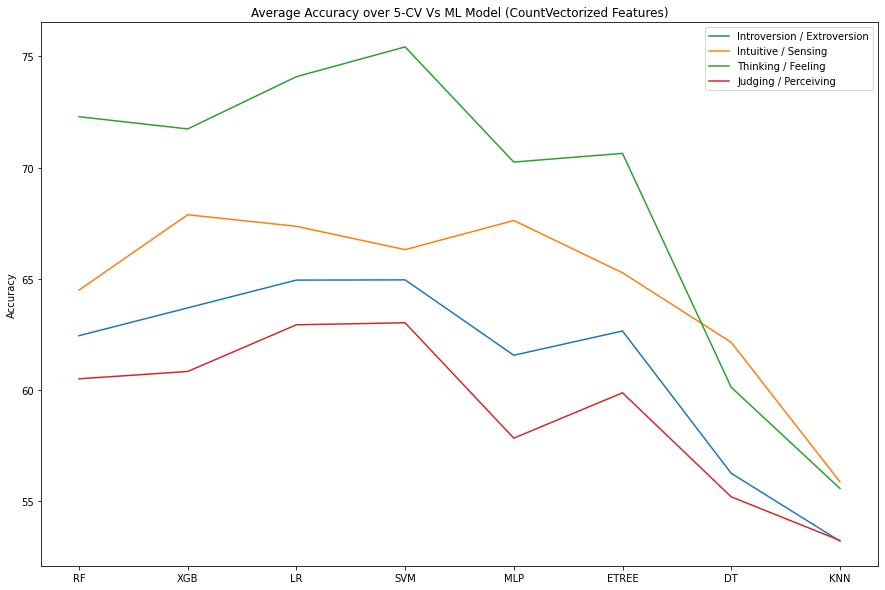

In [ ]:
# RF, XGB, LR, SVM, MLP, ETREE, DT, KNN 
countvect_IE = [62.44, 63.69, 64.94, 64.95, 61.56, 62.65, 56.25, 53.2]
countvect_NS = [64.49, 67.88, 67.36, 66.31, 67.62, 65.27, 62.14, 55.87]
countvect_TF = [72.29, 71.74, 74.09, 75.43, 70.25, 70.64, 60.12, 55.57]
countvect_JP = [60.50, 60.83, 62.93, 63.02, 57.83, 59.87, 55.19, 53.23]

x = ['RF', 'XGB', 'LR', 'SVM', 'MLP', 'ETREE', 'DT', 'KNN' ]

fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, countvect_IE, label = "Introversion / Extroversion")
plt.plot(x, countvect_NS, label = "Intuitive / Sensing")
plt.plot(x, countvect_TF, label = "Thinking / Feeling")
plt.plot(x, countvect_JP, label = "Judging / Perceiving")

plt.ylabel('Accuracy')
plt.title("Average Accuracy over 5-CV Vs ML Model (CountVectorized Features)")

plt.legend()



tfidf

<Figure size 432x288 with 0 Axes>

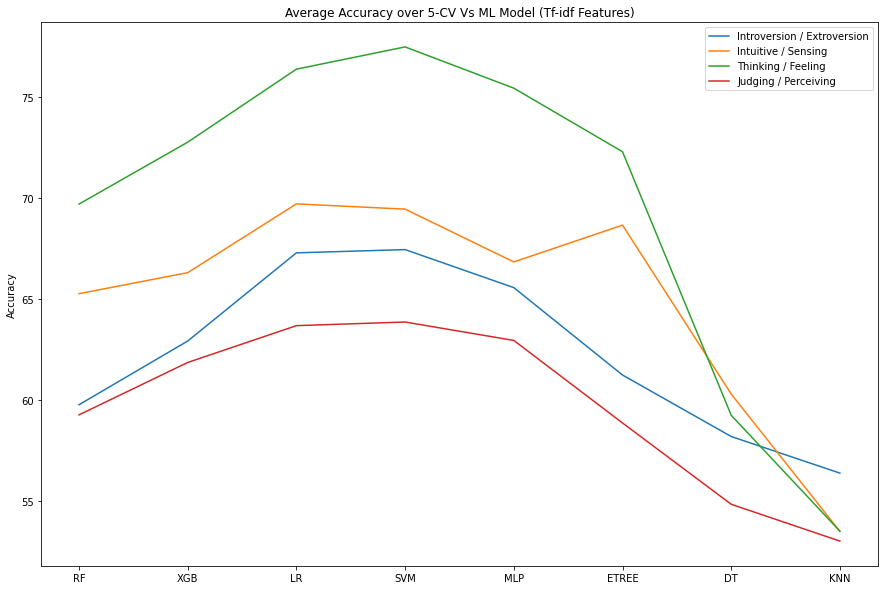

In [ ]:
# RF, XGB, LR, SVM, MLP, ETREE, DT, KNN 
tfidf_IE = [59.78, 62.93, 67.29, 67.45, 65.57, 61.25, 58.21, 56.40]
tfidf_NS = [65.27, 66.31, 69.71, 69.45, 66.84, 68.66, 60.31, 53.52]
tfidf_TF = [69.7, 72.76, 76.37, 77.47, 75.43, 72.29, 59.26, 53.53]
tfidf_JP = [59.28, 61.87, 63.69, 63.87, 62.96, 58.88, 54.86, 53.04]

x = ['RF', 'XGB', 'LR', 'SVM', 'MLP', 'ETREE', 'DT', 'KNN' ]

fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, tfidf_IE, label = "Introversion / Extroversion")
plt.plot(x, tfidf_NS, label = "Intuitive / Sensing")
plt.plot(x, tfidf_TF, label = "Thinking / Feeling")
plt.plot(x, tfidf_JP, label = "Judging / Perceiving")

plt.ylabel('Accuracy')
plt.title("Average Accuracy over 5-CV Vs ML Model (Tf-idf Features)")

plt.legend()



Word2Vec

<Figure size 432x288 with 0 Axes>

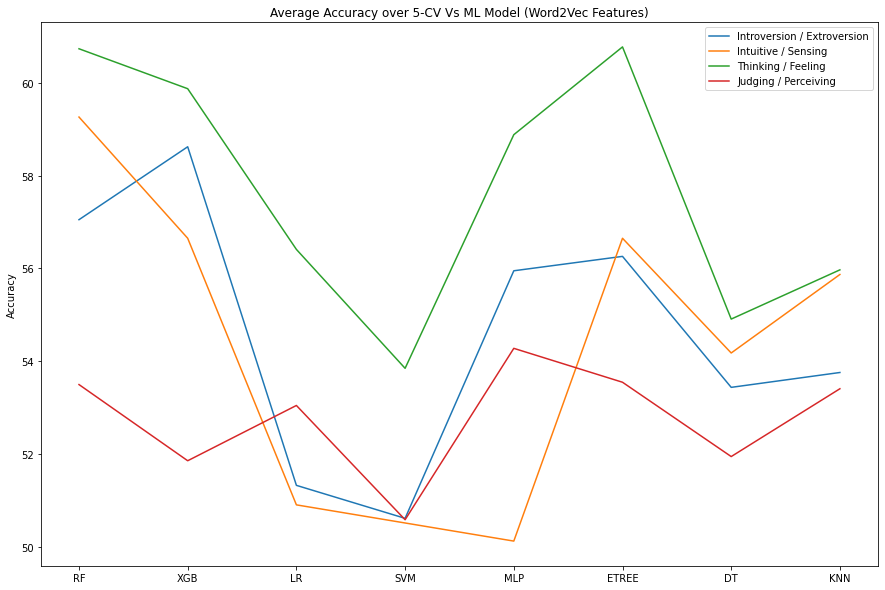

In [ ]:
# RF, XGB, LR, SVM, MLP, ETREE, DT, KNN 
w2v_IE = [57.05, 58.62, 51.33, 50.62, 55.95, 56.26, 53.44, 53.76]
w2v_NS = [59.26, 56.65, 50.91, 50.52, 50.13, 56.65, 54.18, 55.87]
w2v_TF = [60.73, 59.87, 56.41, 53.85, 58.88, 60.77, 54.91, 55.97]
w2v_JP = [53.5, 51.86, 53.05, 50.59, 54.28, 53.55, 51.95, 53.41]

x = ['RF', 'XGB', 'LR', 'SVM', 'MLP', 'ETREE', 'DT', 'KNN' ]

fig = plt.figure()
# fig.suptitle('Model vs Metrics for Introvert/Extropert')
plt.figure(figsize=(15, 10))

plt.plot(x, w2v_IE, label = "Introversion / Extroversion")
plt.plot(x, w2v_NS, label = "Intuitive / Sensing")
plt.plot(x, w2v_TF, label = "Thinking / Feeling")
plt.plot(x, w2v_JP, label = "Judging / Perceiving")

plt.ylabel('Accuracy')
plt.title("Average Accuracy over 5-CV Vs ML Model (Word2Vec Features)")

plt.legend()

